In [1]:
import sys
principal_path = '../'
if principal_path not in sys.path:
    sys.path.append('../')

In [2]:
import pandas as pd
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset
import pickle

from models.PlasticityMNISTModel import PlasticityMNISTModel
from models.MNISTModel import MNISTModel
from copy import copy

from utils import load_data_filtered, find_low_activation_neurons, plot_confusion_matrix, remove_neurons_from_layer, adjust_next_layer

In [3]:
SEED = 2024
pl.seed_everything(SEED)

Seed set to 2024


2024

# [0,1]

In [4]:
checkpoint_ffn = 'checkpoints/mnist_model.ckpt'
model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
model.eval()
print(model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
classes_to_include = [0, 1]
BATCH_SIZE = 32
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, classes_to_include, num_workers=0)

In [7]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.test(model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html

Testing DataLoader 0: 100%|██████████| 67/67 [00:01<00:00, 39.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8278844356536865
        precision           0.8335698246955872
         recall             0.8226253986358643
        test_acc            0.9825059175491333
        test_loss           0.06702230870723724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06702230870723724,
  'test_acc': 0.9825059175491333,
  'precision': 0.8335698246955872,
  'recall': 0.8226253986358643,
  'f1': 0.8278844356536865}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

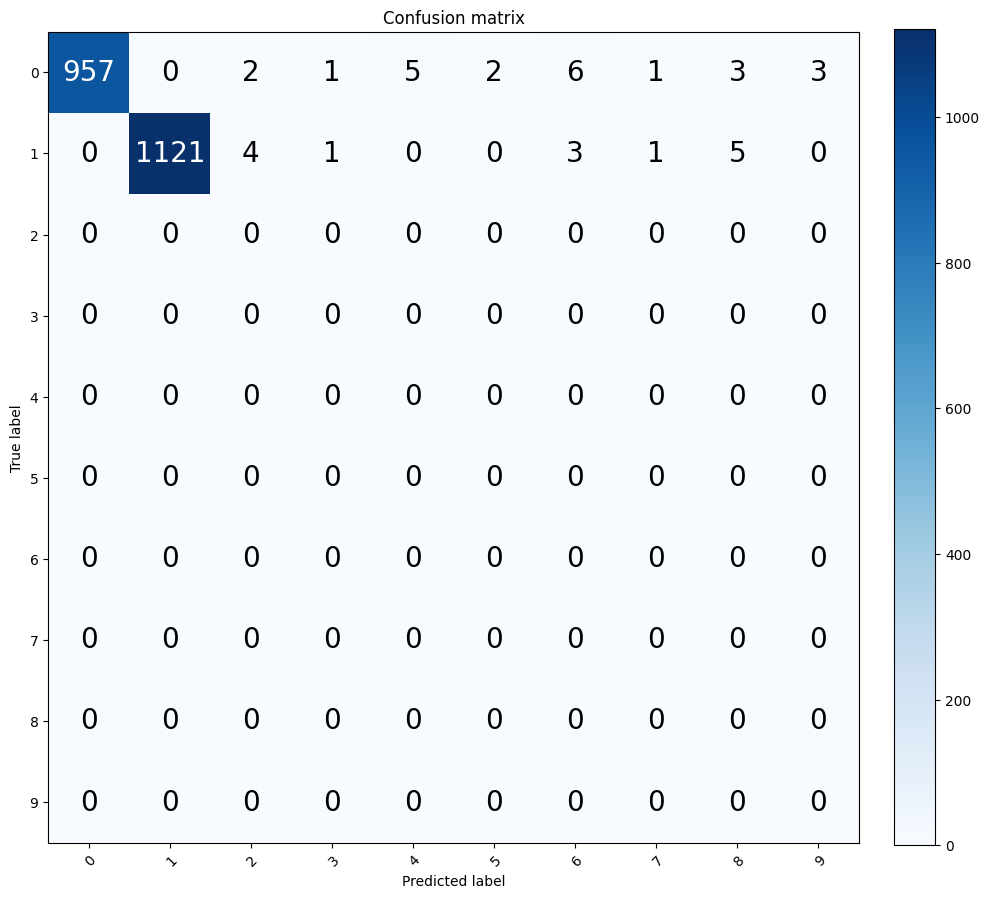

In [8]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered:
    x, y = batch
    y_true += y.tolist()
    y_pred += model(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = ['0', '1']
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

In [6]:
df = pd.read_csv("activations/activations_minist_model.csv")
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.923480,0.000000,...,-16.595833,-14.188923,-8.905098,-10.092788,-22.101274,-15.535633,-29.975979,-0.000180,-14.806216,-13.204277
1,2.0,0.0,0.00000,2.264030,2.359124,0.000000,1.334890,0.000000,0.821211,0.531313,...,-21.110266,-12.353317,-0.000006,-15.052830,-29.732016,-22.506277,-20.308481,-23.745291,-13.633943,-34.262554
2,1.0,0.0,0.59751,0.420798,0.433036,0.000000,0.574497,1.608488,0.000000,0.053121,...,-15.868408,-0.001101,-9.372239,-12.341898,-9.200323,-9.776160,-9.750698,-8.316074,-7.506509,-14.401055
3,0.0,0.0,0.00000,0.270113,0.000000,1.198138,0.000000,0.000000,2.564893,0.000000,...,-0.000514,-13.230165,-9.013961,-16.788416,-12.716939,-12.957210,-9.124060,-12.553201,-12.449683,-8.221807
4,4.0,0.0,0.00000,0.984886,0.000000,0.000000,0.000000,0.000000,1.628678,0.627652,...,-14.683038,-15.717505,-15.271838,-20.522961,-0.000891,-14.758453,-13.264597,-13.595921,-12.924339,-7.031570


In [7]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

df_layer1 = df[get_layer_columns('Layer1')]
df_layer2 = df[get_layer_columns('Layer2')]
#df_layer3 = df[get_layer_columns('Layer3')]

In [8]:
threshold_layer_1 = 0.5
print(f'Threshold layer 1: {threshold_layer_1*100}%')

mask_indices_layer_1 = find_low_activation_neurons(df_layer1, 0, 1, threshold=threshold_layer_1)
print(f'High activation neurons layer: {128 - len(mask_indices_layer_1)}')

threshold_layer_2 = threshold_layer_1
print(f'Threshold layer 2: {threshold_layer_2*100}%')

mask_indices_layer_2 = find_low_activation_neurons(df_layer2, 0, 1, threshold=threshold_layer_2)

print(f'High activation neurons layer: {256 - len(mask_indices_layer_2)}')

Threshold layer 1: 50.0%
High activation neurons layer: 16
Threshold layer 2: 50.0%
High activation neurons layer: 60


In [9]:
modified_model = copy(model)
print(modified_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
new_layer_1, new_weights_1, new_bias_1 = remove_neurons_from_layer(modified_model.layer_1, mask_indices_layer_1)
new_layer_2, new_weights_2 = adjust_next_layer(modified_model.layer_2, mask_indices_layer_1)

# Aplica los nuevos pesos y sesgos
modified_model.layer_1 = new_layer_1
modified_model.layer_1.weight.data = new_weights_1
modified_model.layer_1.bias.data = new_bias_1

modified_model.layer_2 = new_layer_2
modified_model.layer_2.weight.data = new_weights_2
# Los sesgos de layer_2 no cambian a menos que también elimines neuronas de layer_2

new_layer_2, new_weights_2, new_bias_2 = remove_neurons_from_layer(modified_model.layer_2, mask_indices_layer_2)

# Aplicar los nuevos pesos y sesgos a layer_2
modified_model.layer_2 = new_layer_2
modified_model.layer_2.weight.data = new_weights_2
modified_model.layer_2.bias.data = new_bias_2

# Ajustar layer_3 en consecuencia
# Supongamos que layer_3 no tiene neuronas eliminadas directamente, pero sus pesos deben ajustarse debido a los cambios en layer_2
new_layer_3, new_weights_3 = adjust_next_layer(modified_model.layer_3, mask_indices_layer_2)

# Aplicar los nuevos pesos a layer_3
modified_model.layer_3 = new_layer_3
modified_model.layer_3.weight.data = new_weights_3

In [12]:
print(modified_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=60, bias=True)
  (layer_3): Linear(in_features=60, out_features=10, bias=True)
)


In [14]:
# test model
plasticy_model_trainer = pl.Trainer(max_epochs=5)
plasticy_model_trainer.fit(modified_model, train_loader_filtered, val_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 12.6 K
7 | layer_2   | Linear        

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]Failed to save model graph: 'ExperimentWriter' object has no attribute 'add_graph'
Epoch 4: 100%|██████████| 317/317 [00:02<00:00, 152.71it/s, v_num=11, train_loss=6.39e-6, train_acc=1.000, val_loss=0.00554, val_acc=0.998] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Failed to save weights histogram: 'ExperimentWriter' object has no attribute 'add_histogram'
Epoch 4: 100%|██████████| 317/317 [00:02<00:00, 152.42it/s, v_num=11, train_loss=6.39e-6, train_acc=1.000, val_loss=0.00554, val_acc=0.998]


In [15]:
# test model
plasticy_model_trainer.test(modified_model, test_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 159.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.9995154142379761
        precision           0.9996017813682556
         recall             0.9994596838951111
        test_acc            0.9995272159576416
        test_loss          0.0028352132067084312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0028352132067084312,
  'test_acc': 0.9995272159576416,
  'precision': 0.9996017813682556,
  'recall': 0.9994596838951111,
  'f1': 0.9995154142379761}]

In [22]:
# load plasticy model
plasticy_model = PlasticityMNISTModel.load_from_checkpoint(checkpoint_ffn, mask_indices_layer_1=mask_indices_layer_1, mask_indices_layer_2=mask_indices_layer_2)
print(plasticy_model)

PlasticityMNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [23]:
plasticy_model_trainer = pl.Trainer(max_epochs=5)
plasticy_model_trainer.fit(plasticy_model, train_loader_filtered, val_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 100 K 
7 | layer_2   | Lin

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [24]:
plasticy_model_trainer.test(plasticy_model, test_loader_filtered)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.1999029666185379     │
│         precision         │    0.19992025196552277    │
│          recall           │    0.1998918056488037     │
│         test_acc          │    0.9995272159576416     │
│         test_loss         │   0.0024387226440012455   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0024387226440012455,
  'test_acc': 0.9995272159576416,
  'precision': 0.19992025196552277,
  'recall': 0.1998918056488037,
  'f1': 0.1999029666185379}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

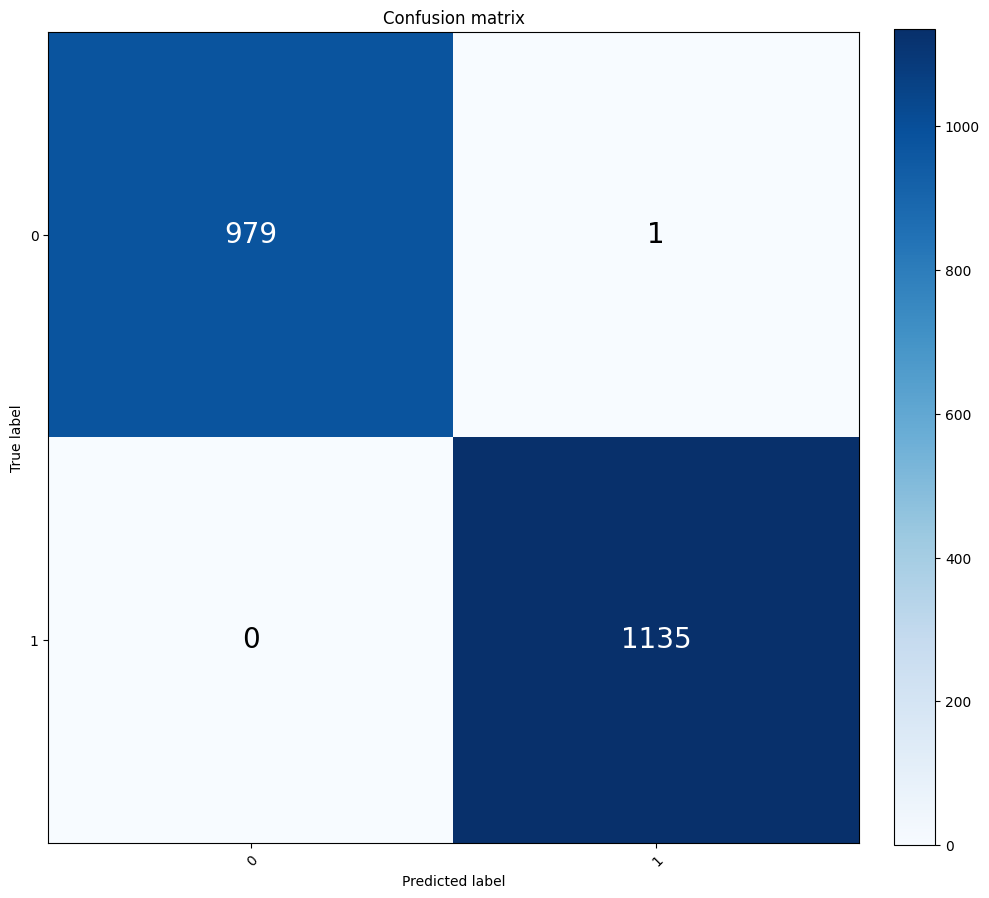

In [25]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered:
    x, y = batch
    y_true += y.tolist()
    y_pred += plasticy_model(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = ['0', '1']
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

In [26]:
# save checkpoint
plasticy_model_trainer.save_checkpoint('checkpoints/plasticy_mnist_model.ckpt')

### study weigths

In [27]:
def extract_weights(model):
    layer_1_pls = model.layer_1.weight.data.cpu().numpy()
    layer_2_pls = model.layer_2.weight.data.cpu().numpy()
    layer_3_pls = model.layer_3.weight.data.cpu().numpy()

    return [layer_1_pls, layer_2_pls, layer_3_pls]

In [28]:
# load plasticy model
plasticy_model_checkpint = 'checkpoints/plasticy_mnist_model.ckpt'
plasticy_model = PlasticityMNISTModel.load_from_checkpoint(plasticy_model_checkpint, mask_indices_layer_1=mask_indices_layer_1, mask_indices_layer_2=mask_indices_layer_2)
plasticy_model.eval()
print(plasticy_model)


PlasticityMNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [29]:
weights_plasticy = extract_weights(plasticy_model)

with open('weights/plasticy_mnist_model_weights.pkl', 'wb') as f:
    pickle.dump(weights_plasticy, f)

In [30]:
#load minist model
mnist_model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
mnist_model.eval()
print(mnist_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [31]:
weights_mnist = extract_weights(mnist_model)

with open('weights/mnist_model_weights.pkl', 'wb') as f:
    pickle.dump(weights_mnist, f)

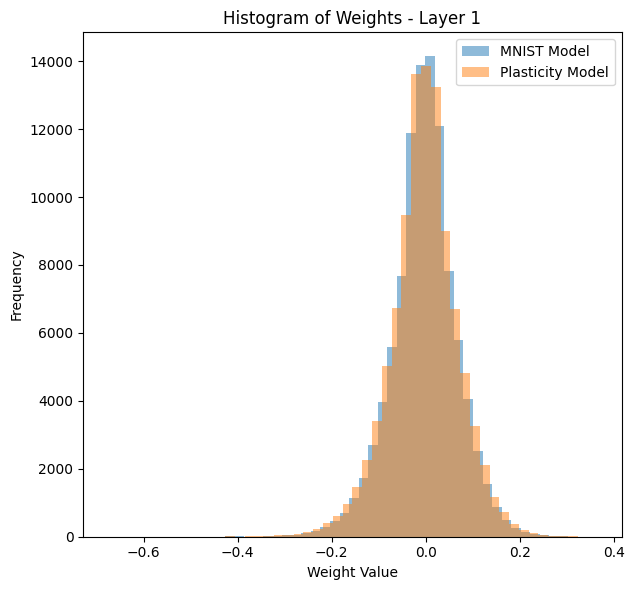

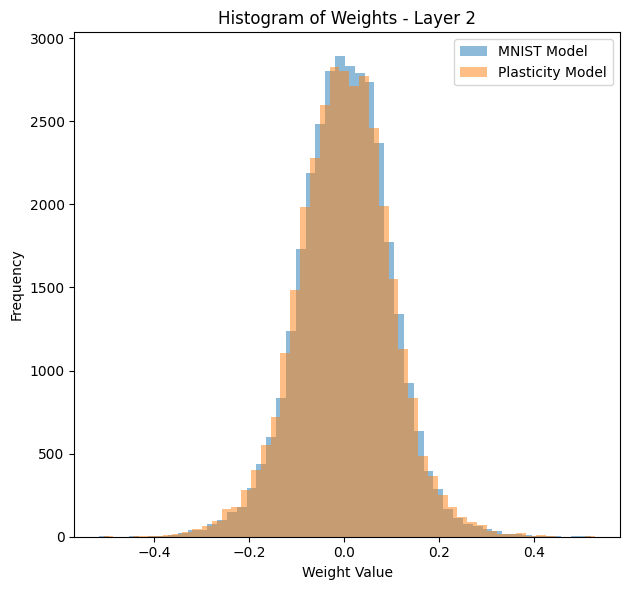

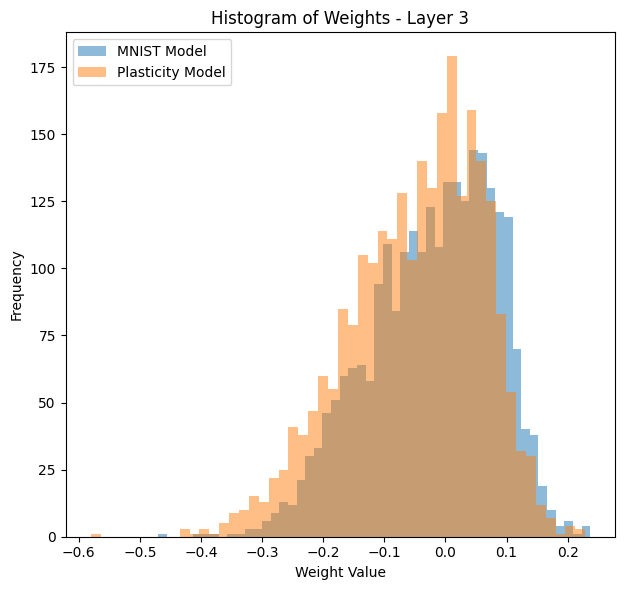

In [32]:
import matplotlib.pyplot as plt

# Function to plot histograms for each layer
def plot_weight_histograms(weights1, weights2, layer_index, label1='Model 1', label2='Model 2'):
    plt.figure(figsize=(12, 6))

    # Layer 1
    plt.subplot(1, 2, 1)
    plt.hist(weights1[layer_index].flatten(), bins=50, alpha=0.5, label=label1)
    plt.hist(weights2[layer_index].flatten(), bins=50, alpha=0.5, label=label2)
    plt.title(f'Histogram of Weights - Layer {layer_index + 1}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot histograms for each layer
for i in range(3):
    plot_weight_histograms(weights_mnist, weights_plasticy, i, label1='MNIST Model', label2='Plasticity Model')


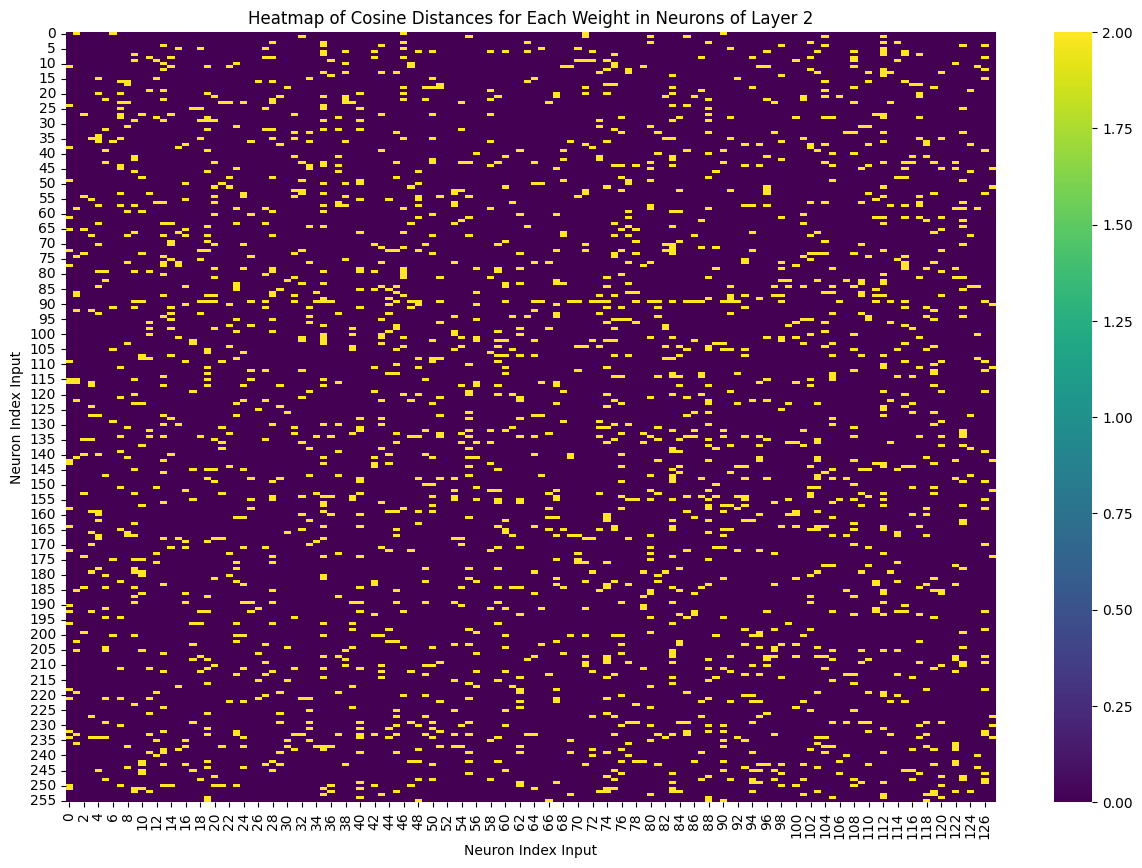

In [33]:
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Function to calculate cosine distance
def cosine_distance(weights1, weights2):
    return cosine(weights1.flatten(), weights2.flatten())

# Calculate Cosine distances for each weight of each neuron in the second layer
# This results in a matrix of size 256 x 128
cosine_distances_layer_2 = np.array([[cosine_distance(weights_mnist[1][i, j], weights_plasticy[1][i, j])
                                      for j in range(weights_mnist[1].shape[1])]
                                      for i in range(weights_mnist[1].shape[0])])

# Generate the heatmap for this matrix
plt.figure(figsize=(15, 10))
plt.title("Heatmap of Cosine Distances for Each Weight in Neurons of Layer 2")
sns.heatmap(cosine_distances_layer_2, annot=False, cmap="viridis", cbar=True)
plt.xlabel("Neuron Index Input")
plt.ylabel("Neuron Index Input")
plt.show()


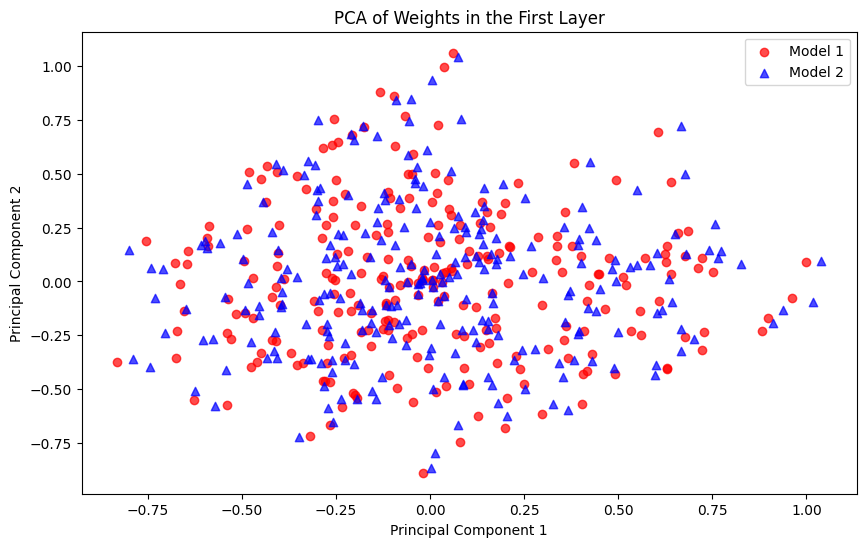

In [34]:
from sklearn.decomposition import PCA

# Flatten the weights for PCA
# Each neuron's weights become a single vector
flattened_weights_model_1 = weights_mnist[1].reshape(weights_mnist[1].shape[0], -1)
flattened_weights_model_2 = weights_plasticy[1].reshape(weights_plasticy[1].shape[0], -1)

# Combine the weights from both models for PCA
combined_weights = np.vstack([flattened_weights_model_1, flattened_weights_model_2])

# Apply PCA to reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_weights = pca.fit_transform(combined_weights)

# Split the reduced weights back into two groups for plotting
reduced_weights_model_1 = reduced_weights[:flattened_weights_model_1.shape[0], :]
reduced_weights_model_2 = reduced_weights[flattened_weights_model_1.shape[0]:, :]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(reduced_weights_model_1[:, 0], reduced_weights_model_1[:, 1], label='Model 1', alpha=0.7, color='red', marker='o')
plt.scatter(reduced_weights_model_2[:, 0], reduced_weights_model_2[:, 1], label='Model 2', alpha=0.7, color='blue', marker='^')
plt.title('PCA of Weights in the First Layer')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


## Re-train with data that is not 0 or 1

In [35]:
classes_to_include = [2, 3, 4, 5, 6, 7, 8, 9]
BATCH_SIZE = 32
train_loader_filtered_2, val_loader_filtered_2, test_loader_filtered_2 = load_data_filtered(BATCH_SIZE, classes_to_include, num_workers=0)

In [36]:
# load MNIST model
mnist_model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
mnist_model.eval()

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
# test model
mnist_model_trainer.test(mnist_model, test_loader_filtered_2)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.7688491940498352     │
│         precision         │    0.7735306620597839     │
│          recall           │    0.7709592580795288     │
│         test_acc          │    0.9733671545982361     │
│         test_loss         │    0.0850386992096901     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0850386992096901,
  'test_acc': 0.9733671545982361,
  'precision': 0.7735306620597839,
  'recall': 0.7709592580795288,
  'f1': 0.7688491940498352}]

In [38]:
# load plasticy model
plasticy_model = PlasticityMNISTModel.load_from_checkpoint(checkpoint_ffn, mask_indices_layer_1=mask_indices_layer_1, mask_indices_layer_2=mask_indices_layer_2)
plasticy_model.eval()

PlasticityMNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)

In [39]:
# test model
plasticy_model_trainer.test(plasticy_model, test_loader_filtered_2)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.7688491940498352     │
│         precision         │    0.7735306620597839     │
│          recall           │    0.7709592580795288     │
│         test_acc          │    0.9733671545982361     │
│         test_loss         │    0.0850386992096901     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0850386992096901,
  'test_acc': 0.9733671545982361,
  'precision': 0.7735306620597839,
  'recall': 0.7709592580795288,
  'f1': 0.7688491940498352}]

In [40]:
anti_mask_indices_layer_1 = [i for i in range(128) if i not in mask_indices_layer_1]
anti_mask_indices_layer_2 = [i for i in range(256) if i not in mask_indices_layer_2]

In [41]:
train_plasticy_model_2 = PlasticityMNISTModel.load_from_checkpoint(checkpoint_ffn, mask_indices_layer_1=anti_mask_indices_layer_1, mask_indices_layer_2=anti_mask_indices_layer_2)

In [43]:
# train model
plasticy_model_trainer = pl.Trainer(max_epochs=5)
plasticy_model_trainer.fit(train_plasticy_model_2, train_loader_filtered_2, val_loader_filtered_2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 100 K 
7 | layer_2   | Linear              | 33.0 K
8 | layer_3   | Linear              | 2.6 K 
--------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [44]:
# test model
plasticy_model_trainer.test(train_plasticy_model_2, test_loader_filtered_2)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.7675656676292419     │
│         precision         │    0.7716416120529175     │
│          recall           │    0.7704095244407654     │
│         test_acc          │    0.9715916514396667     │
│         test_loss         │    0.10412440448999405    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10412440448999405,
  'test_acc': 0.9715916514396667,
  'precision': 0.7716416120529175,
  'recall': 0.7704095244407654,
  'f1': 0.7675656676292419}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

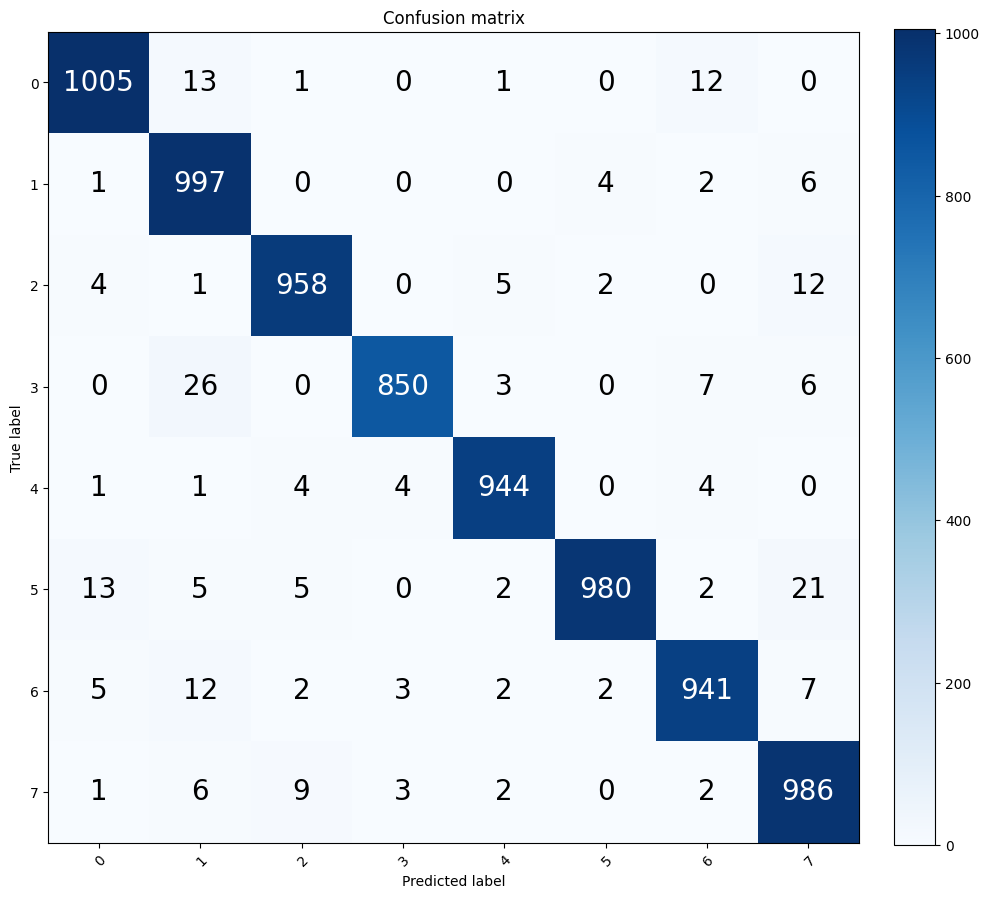

In [45]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered_2:
    x, y = batch
    y_true += y.tolist()
    y_pred += train_plasticy_model_2(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = ['2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

## [0,2,4,6,8] [1,3,5,7,9]